## Things achieved in this notebook:
- Understand column meanings and units
- Label meanings
- Per-subject and per-recording duration
- Any anomalies (e.g., time discontinuities)

In [1]:
import os, re, glob
import numpy as np
import pandas as pd

In [2]:
DATA_DIR = "./modified_dataset"  
PATTERN = os.path.join(DATA_DIR, "*.txt")

In [3]:
EXPECTED_DT_MS = 16.0         # ~0.016 s
DT_TOL_MS = 2.0               # tolerance for "normal" jitter
BIG_GAP_MS = 5 * EXPECTED_DT_MS  # flag gaps >= 80 ms as "big"
NEGATIVE_DT_FLAG = True       # flag if time goes backwards

In [4]:
COLS = [
    "time_ms",
    "ankle_fwd_mg", "ankle_vert_mg", "ankle_lat_mg",
    "thigh_fwd_mg", "thigh_vert_mg", "thigh_lat_mg",
    "trunk_fwd_mg", "trunk_vert_mg", "trunk_lat_mg",
    "annotation"
]

In [5]:
LABEL_MEANING = {
    0: "not experiment / setup / unrelated activity",
    1: "experiment, no freeze (stand/walk/turn)",
    2: "freeze (FoG)"
}

In [6]:
fname_re = re.compile(r"S(\d+)\s*R(\d+)\.txt$", re.IGNORECASE)

## function parse_subject_run
- captures ss (subject_id) and rr (run_id) values

In [7]:
def parse_subject_run(path):
    base = os.path.basename(path)
    m = fname_re.search(base)
    if not m:
        return None, None
    return int(m.group(1)), int(m.group(2))

## function read_file
- read each file 
- check column numbers 
- set headers

In [8]:
def read_file(path):
    df = pd.read_csv(path, sep=r"\s+", header=None, engine="python")
    if df.shape[1] != len(COLS):
        raise ValueError(f"{os.path.basename(path)} has {df.shape[1]} cols, expected {len(COLS)}")
    df.columns = COLS
    return df

## function time_stats
- Compute time differences between consecutive timestamps (Expected value ≈ 16 ms)
- summary statistics about sampling intervals and duration

In [9]:
def time_stats(time_ms):
    t = time_ms.to_numpy()
    dt = np.diff(t)
    if len(dt) == 0:
        return {
            "n_samples": len(t),
            "t_start": float(t[0]) if len(t) else np.nan,
            "t_end": float(t[-1]) if len(t) else np.nan,
            "duration_s": 0.0,
            "dt_mean": np.nan, "dt_median": np.nan, "dt_std": np.nan,
            "dt_min": np.nan, "dt_max": np.nan
        }
    return {
        "n_samples": int(len(t)),
        "t_start": float(t[0]),
        "t_end": float(t[-1]),
        "duration_s": float((t[-1] - t[0]) / 1000.0),
        "dt_mean": float(np.mean(dt)),
        "dt_median": float(np.median(dt)),
        "dt_std": float(np.std(dt)),
        "dt_min": float(np.min(dt)),
        "dt_max": float(np.max(dt)),
    }

## function anomaly_counts
- check if theres any negative time ((time goes backward))
- any big gaps
- any files outside expected time

In [10]:
def anomaly_counts(time_ms):
    t = time_ms.to_numpy()
    if len(t) < 2:
        return {
            "n_dt": 0,
            "n_negative_dt": 0,
            "n_off_dt": 0,
            "n_big_gaps": 0
        }
    dt = np.diff(t)
    n_negative = int(np.sum(dt < 0)) if NEGATIVE_DT_FLAG else 0
    # off_dt: dt outside [EXPECTED_DT_MS - DT_TOL_MS, EXPECTED_DT_MS + DT_TOL_MS]
    lo, hi = EXPECTED_DT_MS - DT_TOL_MS, EXPECTED_DT_MS + DT_TOL_MS
    n_off = int(np.sum((dt < lo) | (dt > hi)))
    n_big = int(np.sum(dt >= BIG_GAP_MS))
    return {
        "n_dt": int(len(dt)),
        "n_negative_dt": n_negative,
        "n_off_dt": n_off,
        "n_big_gaps": n_big
    }

## function anomaly_counts
- no. of samples with annotation 0, 1 and 2
- annotation 0 - removed, not part of experiment
- annotation 1 - no fog samples
- annotation 2 - fog samples

In [11]:
def label_stats(annotation):
    vc = annotation.value_counts(dropna=False).to_dict()
    # Ensure keys 0,1,2 exist
    for k in [0,1,2]:
        vc.setdefault(k, 0)
    total = sum(vc.values())
    return {
        "n_label0": int(vc[0]),
        "n_label1": int(vc[1]),
        "n_label2": int(vc[2]),
        "pct_label0": float(vc[0]/total*100) if total else np.nan,
        "pct_label1": float(vc[1]/total*100) if total else np.nan,
        "pct_label2": float(vc[2]/total*100) if total else np.nan,
        "labels_present": sorted([int(k) for k,v in vc.items() if v>0])
    }

In [64]:
# -----------------------------
# Ingest all files
# -----------------------------
paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.txt")))
COLS = [
    "time_ms",
    "ankle_fwd_mg", "ankle_vert_mg", "ankle_lat_mg",
    "thigh_fwd_mg", "thigh_vert_mg", "thigh_lat_mg",
    "trunk_fwd_mg", "trunk_vert_mg", "trunk_lat_mg",
    "annotation","subject_id","run_id"
]

fname_re = re.compile(r"S(\d+)\s*R(\d+)", re.IGNORECASE)

record_rows = []
bad_files = []

def parse_subject_run(filename):
    m = fname_re.search(filename)
    if not m:
        return None, None
    return int(m.group(1)), int(m.group(2))

for path in paths:
    base = os.path.basename(path)
    sid, rid = parse_subject_run(base)
    if sid is None:
        bad_files.append((base, "Filename did not match SxxRyy pattern"))
        continue

    try:
        df = pd.read_csv(
            path,
            sep=r"\s+",
            header=None,
            engine="python",
            comment="#",
            skip_blank_lines=True
        )
    except Exception as e:
        bad_files.append((base, f"Read error: {e}"))
        continue

    if df.shape[1] != 13:
        bad_files.append((base, f"Expected 11 columns, got {df.shape[1]}"))
        continue

    df.columns = COLS

    # Basic duration
    t = df["time_ms"].to_numpy()
    duration_s = (t[-1] - t[0]) / 1000.0 if len(t) else 0.0

    # dt checks
    dt = np.diff(t)
    n_negative_dt = int(np.sum(dt < 0)) if len(dt) else 0
    n_big_gaps = int(np.sum(dt >= 80)) if len(dt) else 0  # >= 5*16ms
    dt_median = float(np.median(dt)) if len(dt) else np.nan

    # labels
    vc = df["annotation"].value_counts().to_dict()
    n0 = int(vc.get(0, 0)); n1 = int(vc.get(1, 0)); n2 = int(vc.get(2, 0))

    record_rows.append({
        "subject_id": sid,
        "run_id": rid,
        "file": base,
        "n_samples": int(len(df)),
        "duration_min": float(duration_s / 60.0),
        "dt_median_ms": dt_median,
        "n_negative_dt": n_negative_dt,
        "n_big_gaps": n_big_gaps,
        "n_label0": n0,
        "n_label1": n1,
        "n_label2": n2,
    })


In [22]:
records = pd.DataFrame(record_rows).sort_values(["subject_id", "run_id"]).reset_index(drop=True)

In [23]:
records

,subject_id,run_id,file,n_samples,duration_min,dt_median_ms,n_negative_dt,n_big_gaps,n_label0,n_label1,n_label2
0,1,1,S01R01.txt,92802,25.000000,16.0,0,1,0,87655,5147
1,1,2,S01R02.txt,28801,7.500000,16.0,0,0,0,27254,1547
2,2,1,S02R01.txt,25601,6.666667,16.0,0,0,0,22064,3537
3,2,2,S02R02.txt,64961,16.916667,16.0,0,0,0,56889,8072
4,3,1,S03R01.txt,90882,25.166667,16.0,0,1,0,74848,16034
5,3,2,S03R02.txt,16641,4.333333,16.0,0,0,0,14335,2306
6,3,3,S03R03.txt,21121,5.500000,16.0,0,0,0,21121,0
7,4,1,S04R01.txt,132482,36.500000,16.0,0,1,0,132482,0
8,5,1,S05R01.txt,67844,20.166667,16.0,0,3,0,50491,17353
9,5,2,S05R02.txt,65922,18.833333,16.0,0,1,0,52905,13017


- I already removed the 0 labels during preprocessing, hence there are none here
- Sampling interval is stable at 16 ms for each file
- no negative timestamps
- no big gaps (up to 4 ms is okay, very minor timestamp hiccups)
- FoG samples are mostly less than 15% of the time
- some recordings have no FoG at all
- there is lot of variability in FoG across subjects : Eg:  Subject 3 has one run with 16,034 FoG sampleS whearas Subject 10 has zero FoG

## Visualizing the record duration per subject

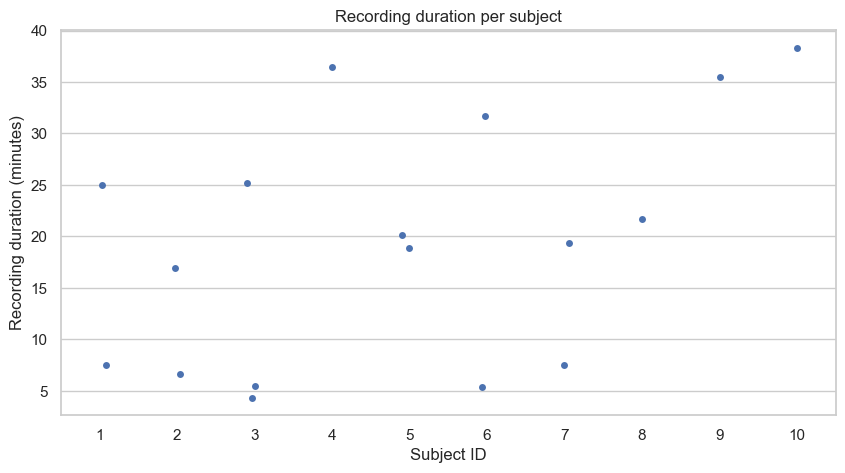

In [30]:
sns.set_theme(style="whitegrid", palette="deep")

plt.figure(figsize=(10, 5))

sns.stripplot(
    data=records,
    x="subject_id",
    y="duration_min"
)

plt.xlabel("Subject ID")
plt.ylabel("Recording duration (minutes)")
plt.title("Recording duration per subject")

plt.show()


- Recording durations vary across subjects and runs, ranging from ~4 to ~38 minutes.

## FoG v/s non FoG distribution per record

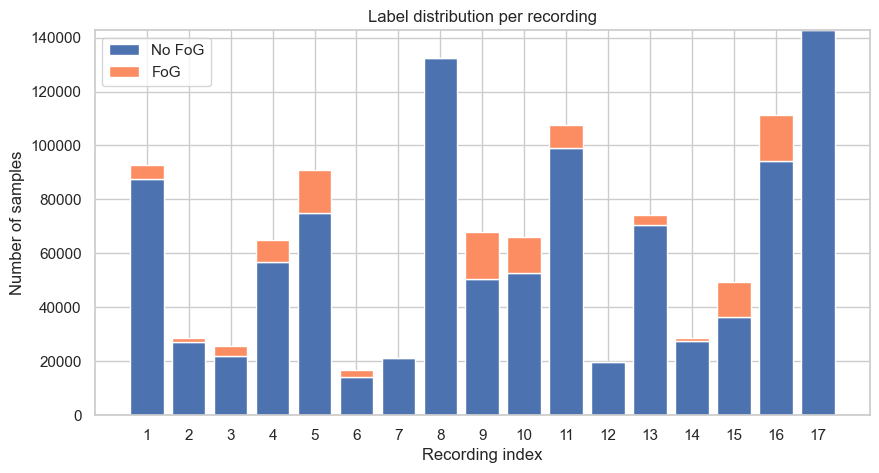

In [35]:
sns.set_theme(style="whitegrid", palette="deep")

x = range(1, len(records) + 1)

plt.figure(figsize=(10, 5))

plt.bar(
    x,
    records["n_label1"],
    label="No FoG"
)

plt.bar(
    x,
    records["n_label2"],
    bottom=records["n_label1"],
    label="FoG",
    color=sns.color_palette("Set2")[1]
)

plt.xlabel("Recording index")
plt.ylabel("Number of samples")
plt.title("Label distribution per recording")
plt.xticks(x)
plt.legend()

plt.show()

- this bar plot shows a clear class imbalance of FoG v/s non FoG across runs
- some runs dont have FoG

## FoG burden per subject

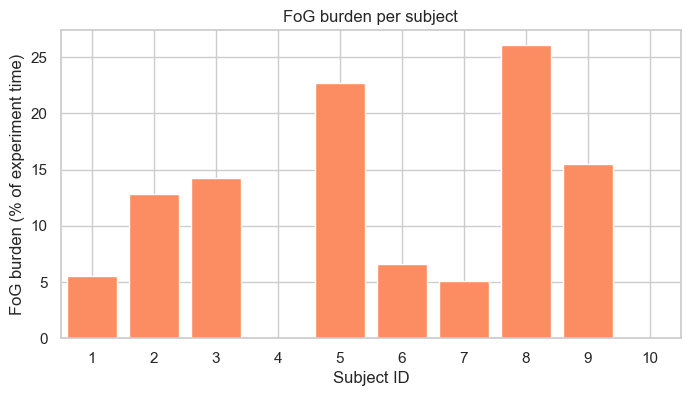

In [55]:
plt.figure(figsize=(8, 4))

plt.bar(
    subj["subject_id"],
    subj["fog_pct"],
    color=sns.color_palette("Set2")[1]
)

plt.xlabel("Subject ID")
plt.ylabel("FoG burden (% of experiment time)")
plt.title("FoG burden per subject")

plt.xticks(range(1, 11))
plt.xlim(0.5, 10.5)

plt.show()


- subject 8 and 5 are most impacted, spending up to 30% of the experiment in FoG state
- There is a huge variability across all subjects

## Out of the total experiment time, how much was spent in FoG for each subject?

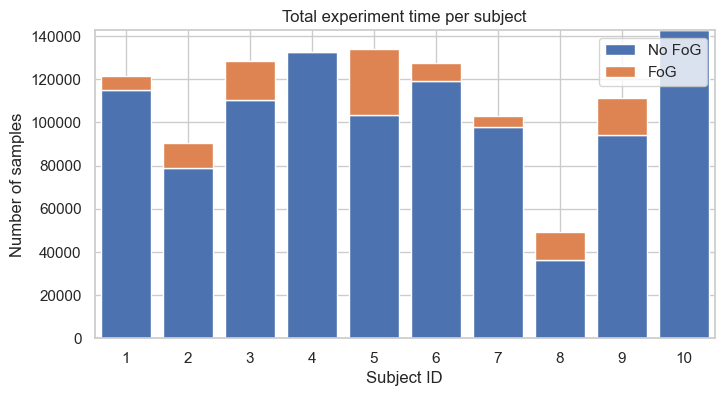

In [53]:
plt.figure(figsize=(8, 4))
plt.bar(subj["subject_id"], subj["label1"], label="No FoG")
plt.bar(subj["subject_id"], subj["label2"],
        bottom=subj["label1"], label="FoG")

plt.xlabel("Subject ID")
plt.ylabel("Number of samples")
plt.title("Total experiment time per subject")

plt.xticks(range(1, 11))
plt.xlim(0.5, 10.5)

plt.legend()
plt.show()

## Timeline plot for subject recording S0501 

In [75]:
df_ex = pd.read_csv(
            "./modified_dataset/S05R01.txt",
            sep=r"\s+",
            header=None,
            engine="python",
            comment="#",
            skip_blank_lines=True
)

In [77]:
df_ex.columns = COLS

In [78]:
df_ex

,time_ms,ankle_fwd_mg,ankle_vert_mg,ankle_lat_mg,thigh_fwd_mg,thigh_vert_mg,thigh_lat_mg,trunk_fwd_mg,trunk_vert_mg,trunk_lat_mg,annotation,subject_id,run_id
0,440000,-101,1019,198,81,981,80,-106,1019,-116,1,5,1
1,440015,-111,1009,207,72,981,50,-97,1000,-87,1,5,1
2,440031,-90,1009,217,81,981,80,-97,1000,-87,1,5,1
3,440046,-101,1019,217,72,990,70,-97,1009,-87,1,5,1
4,440062,-90,1009,227,90,981,70,-116,1019,-97,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67839,1649937,-50,852,653,590,712,585,-1087,352,135,1,5,1
67840,1649953,-20,843,673,618,703,616,-1067,390,29,1,5,1
67841,1649968,-40,843,643,618,685,606,-1048,409,0,1,5,1
67842,1649984,-30,784,673,645,657,555,-1058,361,9,1,5,1


In [92]:
# Explicit seaborn default colors
BLUE, ORANGE = sns.color_palette("deep")[:2]

def plot_fog_timeline(df_ex, sid=None, rid=None):
    # Expect columns: time_ms, annotation (1=No FoG, 2=FoG)
    t = df_ex["time_ms"].to_numpy(dtype=float) / 1000.0  # seconds
    a = df_ex["annotation"].to_numpy()

    # Ensure sorted by time
    order = np.argsort(t)
    t = t[order]
    a = a[order]

    # Find change points
    change_idx = np.flatnonzero(np.r_[True, a[1:] != a[:-1]])
    starts = t[change_idx]
    ends = np.r_[t[change_idx[1:] - 1], t[-1]]
    states = a[change_idx]

    # Build segments
    fog_segments = []
    nofog_segments = []

    for s, e, st in zip(starts, ends, states):
        if st == 2:   # FoG
            fog_segments.append((s, e - s))
        else:         # No FoG
            nofog_segments.append((s, e - s))

    fig, ax = plt.subplots(figsize=(10, 2.5))

    # Draw timeline bars
    ax.broken_barh(
        nofog_segments, (0.6, 0.3),
        facecolors=BLUE, label="No FoG"
    )

    ax.broken_barh(
        fog_segments, (0.6, 0.3),
        facecolors=ORANGE, label="FoG"
    )

    ax.set_ylim(0, 1.5)
    ax.set_yticks([])
    ax.set_xlabel("Time (s)")

    title = "FoG annotation timeline"
    if sid is not None and rid is not None:
        title += f" : Subject {sid}, Run {rid}"
    ax.set_title(title)

    ax.legend(loc="upper right", frameon=True)
    sns.despine(left=True)

    plt.tight_layout()
    plt.show()


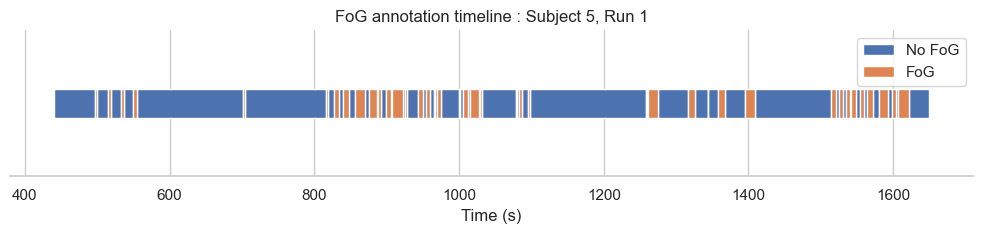

In [93]:
plot_fog_timeline(df_ex, sid=sid, rid=rid)